# The Tolman–Oppenheimer–Volkoff equations (Lindblom's form)- Part II
We study the log-entalpy formulation of the Oppenheimer–Volkoff equations (also known as Lindblom's form). This formulation (here taken from [Martin Jakob Steil's thesis](https://theorie.ikp.physik.tu-darmstadt.de/nhq/downloads/thesis/master.steil.pdf) in Section 3.2.3) 
has several advantages w.r.t. the original formulation by Tolman–Oppenheimer–Volkoff:

* It directly describes the radius and mass of the star.
* It has a known integration domain.
* It is not stiff.

In this formulation, the state is:

$$
\mathbf x=[r^2, m/r]=[x_0, x_1]
$$,

and the parameters are:

$$
\mathbf p = [\eta_K, \eta_\Gamma]
$$,

 where $K = \overline K(1+\eta_K)$ and $\Gamma = \overline \Gamma(1+\eta_\Gamma)$ will parameterize the equation of state of a polytrope (a gaseous sphere in hydrodynamic equilibrium).

The equations are then written as:

$$\Large
\left\{
\begin{array}{ll}
\frac{dx_0}{dh} &= -\frac{2x_0 (1-2x_1)}{4\pi x_0 P(h) + x_1}\\
\frac{dx_1}{dh} &= \left(2\pi \epsilon(h) - \frac{x_1}{2x_0}\right) \frac{dx_0}{dh} \\
\end{array}\right.
$$

where an equation of state is needed to define the pressure $P(h)$ and energy density $\epsilon(h)$ expressions. 

In the case of a relativistic polytrope here studied, the log-entalpy is introduced and defined as:

$$
h = \log{[(\epsilon+P) / \rho]}
$$

where $\rho$ is the (baryonic) mass density (following a [polytropic process](https://en.wikipedia.org/wiki/Polytropic_process)):

$$\Large
\begin{array}{l}
\rho = (\frac{P}{K})^{1/\Gamma} \\
\epsilon = \rho + P / (\Gamma-1)
\end{array}
$$

Hence, in this case the log-entalpy can be written as:
$$
h = \log\left(1 + \frac{\Gamma}{\Gamma-1} K^{\frac 1\Gamma} P^{1-\frac 1\Gamma}\right)
$$

which can be inverted to yield the $P(h)$ form:
$$
P(h) = K^{-\frac{1}{\Gamma-1}}\left[\frac{\Gamma-1}{\Gamma}\left(e^h-1\right)\right]^{\frac{\Gamma}{\Gamma-1}}
$$


**Note**: the dynamics is singular at $h=0$ (of a removable kind), so we will need to define the initial conditions at some small $\delta h$ where the singularity is not present.


In [1]:
import heyoka as hy
import numpy as np
from scipy import optimize
from copy import deepcopy

import time

import matplotlib.pyplot as plt

# 0 - Preamble 
Let us start introducing the common definition and some reference numerical values fo the parameters.

In [2]:
# State variables
x0, x1 = hy.make_vars("x0", "x1")

# The independent variable is log-enthalpy not time, thus we rename it as follows:
h = hy.time

# Parameters values.
Gamma_v = 2.0
K_v = 100.0

# Parameters expressions w.r.t. heyoka parameters defined.
Gamma = Gamma_v * (1.0 + hy.par[0])
K = K_v * (1.0 + hy.par[1])

# Other expressions
P = hy.exp(hy.log(K) * (-1.0 / (Gamma - 1.0))) * hy.exp(
    hy.log((Gamma - 1.0) / Gamma * (hy.exp(h) - 1.0)) * (Gamma / (Gamma - 1.0))
)
rho = hy.exp(hy.log(P / K) / Gamma)
eps = rho + P / (Gamma - 1.0)

# The dynamics
dx0dh = -2.0 * x0 * (1.0 - 2.0 * x1) / (4.0 * np.pi * x0 * P + x1)
dyn = [
    (x0, dx0dh),
    (x1, (2.0 * np.pi * eps - x1 / 2.0 / x0) * dx0dh),
]

# 1 - Standard Numerical Solution
The Tolman–Oppenheimer–Volkoff equations in the Lindblom form are numerically well behaved. 

We here show a straight forward numerical integration using the Taylor adaptive scheme of *heyoka*.

In [3]:
# We instantiate the numerical ODE solver
ta = hy.taylor_adaptive(dyn, state=[1.0, 1.0], time=0.1, tol=1e-16)

We want to define the initial conditions (close to the star center) on the energy density / pressure, to then compute the value of the log-entalpy. To do so, as to compute $P_c$ from $\epsilon_c$ we invert numerically the nonlinear relation between $P$ and $\epsilon$.

In [4]:
# These helper functions help going from pressure to energy density and vice-versa
def eps_from_P(P, Gamma, K):
    return pow(P / K, 1. / Gamma) + P / (Gamma - 1.)

def P_from_eps_root(P, eps_c, Gamma, K):
    return pow(P / K, 1. / Gamma) + P / (Gamma - 1.) - eps_c

In [5]:
# We define the initial conditions from the energy density at the star center
eps_c = 1.444e-3

# We derive the conditions at the center for all other variales
P_c_approx = K_v * pow(
    eps_c, Gamma_v
)  # approx. value for setting bounds in root finding.

P_c = optimize.brentq(
    P_from_eps_root,
    0.5 * P_c_approx,
    10 * P_c_approx,
    args=(eps_c, Gamma_v, K_v),
    xtol=1e-16,
)

h_c = np.log(
    1 + Gamma_v / (Gamma_v - 1) * K_v ** (1 / Gamma_v) * P_c ** (1.0 - 1.0 / Gamma_v)
)

rho_c = (P_c / K_v) ** (1.0 / Gamma_v)

eps_c = rho_c + P_c / (Gamma_v - 1.0)

print("Conditions at the star center:")
print("\nPressure: ", P_c)
print("Energy density: ", eps_c)
print("Density: ", rho_c)
print("log-entalpy: ", h_c)

Conditions at the star center:

Pressure:  0.00016387261275696853
Energy density:  0.0014440000000000058
Density:  0.0012801273872430374
log-entalpy:  0.2279523524331177


From the conditions at the star center we derive the initial conditions of our numerical integrator offsetting the entalpy by a small amount, thus avoiding the numerical (removable) singularity in the dynamics:

In [6]:
# Since the dynamics is singular at h_c, we define the initial conditions at h_0 = h_c - dh
dh = 1e-6 # note that if this gets too small the variational equation may have numerical issues at h_0.
h_0 = h_c-dh

# Initial conditions at h_0 (from Steil thesis). Can be improved at second order.
x0_0 = 3.0 / (2.0 * np.pi * (3.0 * P_c + eps_c)) * dh
x1_0 = 2.0 * eps_c / (3*P_c+eps_c) * dh
y_0 = [x0_0, x1_0]

We are now ready to perform a numerical integration, and extract from the result the star radius and mass:

In [7]:
start = time.time()
ta.time = h_0
ta.state[:] = y_0
ta.pars[:] = [0., 0.]
time_grid = np.linspace(h_0, 0., 100) 
sol = ta.propagate_grid(time_grid)
time_cost = time.time() - start
print("Total time to propagate:", time_cost)
print("Outcome (should be time_limit if all went well): ", str(sol[0]).split(".")[1])

# The mass and radius are easily computed from the last value reached
rf = np.sqrt(sol[-1][:,0][-1])
Mf = sol[-1][:,1][-1] * rf

print("Final value for the stellar radius is: ", rf)
print("Final value for the stellar mass is: ", Mf)

Total time to propagate: 0.0004000663757324219
Outcome (should be time_limit if all went well):  time_limit
Final value for the stellar radius is:  9.585429276546963
Final value for the stellar mass is:  1.4002084368908359


we now plot the results of the numerical integration.

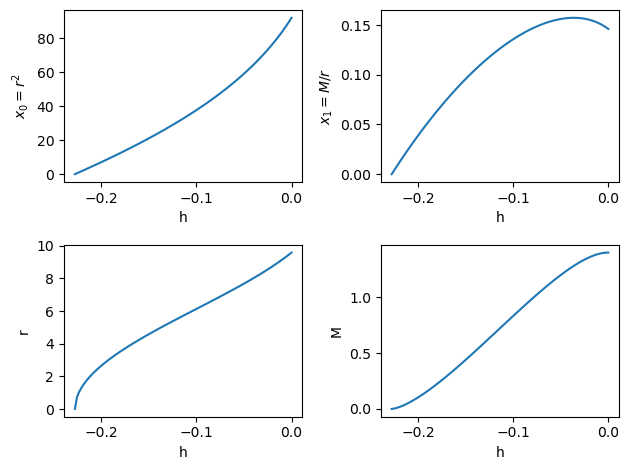

In [8]:
r2_plot = sol[-1][:,0]
mr_plot = sol[-1][:,1]

# Plots
ax = plt.subplot(2,2,1)
ax.plot(-time_grid, r2_plot)
ax.set_xlabel("h")
ax.set_ylabel("$x_0 = r^2$")

ax = plt.subplot(2,2,2)
ax.plot(-time_grid, mr_plot)
ax.set_xlabel("h")
ax.set_ylabel("$x_1 = M / r$")

ax = plt.subplot(2,2,3)
ax.plot(-time_grid, np.sqrt(r2_plot))
ax.set_xlabel("h")
ax.set_ylabel("r")

ax = plt.subplot(2,2,4)
ax.plot(-time_grid, mr_plot*np.sqrt(r2_plot))
ax.set_xlabel("h")
ax.set_ylabel("M")
plt.tight_layout()


# 2 - Variational equations
We seek an analytical expression for the stellar mass and radius, as a function of the variation of the conditions at the stellar center $\delta h_c$. 

In order to obtain the expressions seeked, a variational equation for the initial value of the entalpy (the independent variable) $h_0$ is also needed. We thus introduce a last variable change $\overline h_0 s = h$ so that the differential equations become:

$$\Large
\left\{
\begin{array}{ll}
\frac{dx_0}{ds} &= - \overline h_0 \frac{2x_0 (1-2x_1)}{4\pi x_0 P(s) + x_1}\\
\frac{dx_1}{ds} &= \left(2\pi \epsilon(s) - \frac{x_1}{2x_0}\right) \frac{dx_0}{ds} \\
\end{array}\right.
$$

with:
$$
P(s) = K^{-\frac{1}{\Gamma-1}}\left[\frac{\Gamma-1}{\Gamma}\left(e^{\overline h_0 s}-1\right)\right]^{\frac{\Gamma}{\Gamma-1}}
$$

and:
$$\Large
\begin{array}{l}
\rho(s) = \left(\frac{P(s)}{K}\right)^{1/\Gamma} \\
\epsilon(s) = \rho + P(s) / (\Gamma-1)
\end{array}
$$
and must be integrated for $s \in [1, 0]$, which will correspond to $h \in [\overline h_0, 0]$

In [9]:
# The independent variable is s, not h = log(entalpy) nor t.
s = hy.time

# Important expressions
P = hy.exp(hy.log(K) * (-1.0 / (Gamma - 1.0))) * hy.exp(
    hy.log((Gamma - 1.0) / Gamma * (hy.exp(h) - 1.0)) * (Gamma / (Gamma - 1.0))
)
rho = hy.exp(hy.log(P / K) / Gamma)
eps = rho + P / (Gamma - 1.0)

# Important expressions
P = hy.exp(hy.log(K) * (-1.0 / (Gamma - 1.0))) * hy.exp(
    hy.log((Gamma - 1.0) / Gamma * (hy.exp( hy.par[2]*s) - 1.0)) * (Gamma / (Gamma - 1.0))
)
rho = hy.exp(hy.log(P / K) / Gamma)
eps = rho + P / (Gamma - 1.0)

# We define the dynamics
dx0ds = (-2.0 * x0 * (1.0 - 2.0 * x1) / (4.0 * np.pi * x0 * P + x1)) * hy.par[2]
dyn2 = [
    (x0, dx0ds),
    (x1, (2.0 * np.pi * eps - x1 / 2.0 / x0) * dx0ds),
]

In [10]:
# We augment the dynamics with the variational equations
var_sys = hy.var_ode_sys(dyn2, args=[x0, x1, hy.par[2]], order=5)

# We instantiate the Taylor adaptive integrator for the system of equations augmented with the variational ones
ta_var = hy.taylor_adaptive(
    var_sys,
    state=[1.0, 1.0],
    time=0.1,
    tol=1e-18,
    compact_mode=True,
)
# We copy, for future reference, the initial conditions on the variational state
ic_var = list(deepcopy(ta_var.state[2:]))

In [11]:
start = time.time()
ta_var.time = 1.

ta_var.state[:] = y_0 + ic_var
ta_var.pars[:] = [0., 0., h_0]

s_grid = np.linspace(1.,0., 100)
sol_var = ta_var.propagate_grid(s_grid)
print("Total time to propagate:", time.time() - start)
print("Outcome: ", sol_var[0])

rf = np.sqrt(sol_var[-1][:,0][-1])
Mf = sol_var[-1][:,1][-1] * rf

print("Final value for the stellar radius is: ", rf)
print("Final value for the stellar mass is: ", Mf)

Total time to propagate: 0.24911785125732422
Outcome:  taylor_outcome.time_limit
Final value for the stellar radius is:  9.58542927654696
Final value for the stellar mass is:  1.4002084368908356


We have thus computed the following polynomial approximations (degree $k$):

$$
\begin{array}{l}
R_{\odot} = \mathcal P^k_R(\delta x_{0_0}, \delta x_{1_0},\delta h_0) \\
M_{\odot} = \mathcal P^k_M(\delta x_{0_0}, \delta x_{1_0}, \delta h_0) 
\end{array}
$$

Note the underscript $0$ refers to the initial values, not to the star center which would here be indicated using $c$ rather than $0$.

In [12]:
# Lets change the conditions at the center by some amount (small)
eps_c_new = 1.444e-3*(1-0.95)

# We derive the conditions at the center for all other variales
P_c_approx_new = K_v * pow(
    eps_c_new, Gamma_v
)  # approx. value for setting bounds in root finding.

P_c_new = optimize.brentq(
    P_from_eps_root,
    0.5 * P_c_approx_new,
    10 * P_c_approx_new,
    args=(eps_c_new, Gamma_v, K_v),
    xtol=1e-16,
)

h_c_new = np.log(
    1 + Gamma_v / (Gamma_v - 1) * K_v ** (1 / Gamma_v) * P_c_new ** (1.0 - 1.0 / Gamma_v)
)

rho_c_new = (P_c_new / K_v) ** (1.0 / Gamma_v)
eps_c_new = rho_c_new + P_c_new / (Gamma_v - 1.0)

print("New conditions at the star center:")
print("\nPressure: ", P_c_new)
print("Energy density: ", eps_c_new)
print("Density: ", rho_c_new)
print("log-entalpy: ", h_c_new)

New conditions at the star center:

Pressure:  5.138898390014825e-07
Energy density:  7.220000000000007e-05
Density:  7.168611016099859e-05
log-entalpy:  0.014235415987847225


We may now find the new starting conditions at $h_c-dh$.

In [13]:
# Since the dynamics is singular at h_c, we define the initial conditions at h_0 = h_c - dh
h_0_new = h_c_new-dh

# Initial conditions at h_0 (from Steil thesis). Can be improved at second order.
x0_0_new = 3.0 / (2.0 * np.pi * (3.0 * P_c_new + eps_c_new)) * dh
x1_0_new = 2.0 * eps_c_new / (3*P_c_new+eps_c_new) * dh
y_0_new = [x0_0_new, x1_0_new]

We can now use the Taylor approximation to compute the stellar radius and mass:


In [14]:
taylor_approx = ta_var.eval_taylor_map([x0_0_new-x0_0, x1_0_new-x1_0, h_0_new-h_0])
rf_new_taylor = np.sqrt(taylor_approx[0])
Mf_new_taylor = taylor_approx[1] * rf_new_taylor

print("Final value for the stellar radius is: ", rf_new_taylor)
print("Final value for the stellar mass is: ", Mf_new_taylor)

Final value for the stellar radius is:  12.250055589162079
Final value for the stellar mass is:  0.15958902274195394


We now compute these values by numerical integration.

In [15]:
start = time.time()
ta.time = h_0_new
ta.state[:] = y_0_new
ta.pars[:] = [0., 0.]
time_grid = np.linspace(h_0_new, 0., 100) 
sol_new = ta.propagate_grid(time_grid)
time_cost = time.time() - start
print("Total time to propagate:", time_cost)
print("Outcome (should be time_limit if all went well): ", str(sol_new[0]).split(".")[1])

# The mass and radius are easily computed from the last value reached
rf_new = np.sqrt(sol_new[-1][:,0][-1])
Mf_new = sol_new[-1][:,1][-1] * rf_new

print("Final value for the stellar radius is: ", rf_new)
print("Final value for the stellar mass is: ", Mf_new)

Total time to propagate: 0.00030493736267089844
Outcome (should be time_limit if all went well):  time_limit
Final value for the stellar radius is:  12.290448364837635
Final value for the stellar mass is:  0.16937365361442608


Lets see the error introduced by the Taylor approximation:

In [16]:
print("Absolute error on mass:", Mf_new-Mf_new_taylor)
print("Absolute error on radius:", rf_new-rf_new_taylor)

print("\nRelative error on mass:", (Mf_new-Mf_new_taylor) / Mf_new)
print("Relative error on radius:", (rf_new-rf_new_taylor) / rf_new)

Absolute error on mass: 0.009784630872472139
Absolute error on radius: 0.040392775675556436

Relative error on mass: 0.057769497579278475
Relative error on radius: 0.003286517666118526


We now loop over different star conditions (at the core) and plot the relation between mass and radius using the Taylor approximation.

In [23]:
Rstar=[]
Mstar = []
eps_grid = np.linspace(eps_c*(1.-0.95), eps_c*(1+3.),1000)
for eps_c_new in eps_grid:
    # We derive the conditions at the center for all other variales
    P_c_approx_new = K_v * pow(
        eps_c_new, Gamma_v
    )  # approx. value for setting bounds in root finding.

    P_c_new = optimize.brentq(
        P_from_eps_root,
        0.5 * P_c_approx_new,
        10 * P_c_approx_new,
        args=(eps_c_new, Gamma_v, K_v),
        xtol=1e-16,
    )

    h_c_new = np.log(
        1 + Gamma_v / (Gamma_v - 1) * K_v ** (1 / Gamma_v) * P_c_new ** (1.0 - 1.0 / Gamma_v)
    )

    rho_c_new = (P_c_new / K_v) ** (1.0 / Gamma_v)
    eps_c_new = rho_c_new + P_c_new / (Gamma_v - 1.0)

    # Since the dynamics is singular at h_c, we define the initial conditions at h_0 = h_c - dh
    h_0_new = h_c_new-dh

    # Initial conditions at h_0 (from Steil thesis). Can be improved at second order.
    x0_0_new = 3.0 / (2.0 * np.pi * (3.0 * P_c_new + eps_c_new)) * dh
    x1_0_new = 2.0 * eps_c_new / (3*P_c_new+eps_c_new) * dh
    taylor_approx = ta_var.eval_taylor_map([x0_0_new-x0_0, x1_0_new-x1_0, h_0_new-h_0])
    Rstar.append(np.sqrt(taylor_approx[0]))
    Mstar.append(taylor_approx[1]*np.sqrt(taylor_approx[0]))

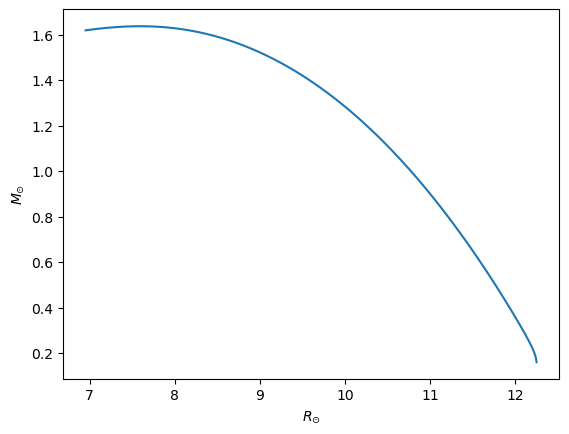

In [24]:
plt.plot(Rstar, Mstar)
plt.xlabel("$R_{\odot}$")
plt.ylabel("$M_{\odot}$");